In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta

In [2]:
#load sp500 data

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

end_date = '2023-09-27'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

sp500 = sp500[pd.to_datetime(sp500["Date added"])<start_date]

symbols_list = sp500['Symbol'].unique().tolist()

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack(future_stack=True)

df.columns = df.columns.str.lower()

[*********************100%%**********************]  345 of 345 completed


In [3]:
#calculate features

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*(np.log(df['adj close']) - np.log(df['open']))**2
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [4]:
#aggregate to monthly level

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('Ticker')['dollar_volume'].resample('ME').mean().stack('Ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack('Ticker', future_stack=True)], axis=1).dropna()

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('Date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [6]:
#calculate mmonthly returns for different time horizons
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df
data = data.groupby('Ticker', group_keys=False).apply(calculate_returns).dropna()

In [7]:
#download fama franch factors and calculate rolling betas
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF', axis =1 )
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data = factor_data.join(data['return_1m']).sort_index()

C:\Users\Thoma\AppData\Local\Temp\ipykernel_26228\668726976.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF', axis =1 )
C:\Users\Thoma\AppData\Local\Temp\ipykernel_26228\668726976.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF', axis =1 )
C:\Users\Thoma\AppData\Local\Temp\ipykernel_26228\668726976.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  factor_data = factor_data.resample('M').last().div(100)


In [8]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

In [9]:
betas = (factor_data.groupby(level=1, group_keys=False)
.apply(lambda x: RollingOLS(endog=x['return_1m'],
                            exog=sm.add_constant(x.drop('return_1m', axis=1)),
                            window=min(24, x.shape[0]),
                            min_nobs=len(x.columns)+1)
 .fit()
 .params
 .drop('const', axis=1)))
       

In [10]:
factors = ['Mkt-RF', 'SMB',	'HML', 'RMW', 'CMA']
data = (data.join(betas.groupby('Ticker').shift()))



In [11]:
data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [12]:
data = data.dropna()
data = data.drop('adj close', axis=1)
data.info

<bound method DataFrame.info of                    garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2017-10-31 AAL            -0.000363  41.051805  3.849110  3.921750  3.994389   
           AAPL           -0.001105  69.196718  3.593605  3.640476  3.687347   
           ABBV           -0.036142  55.247920  4.187696  4.234051  4.280405   
           ABT            -0.005677  53.844867  3.887384  3.910952  3.934519   
           ACN            -0.004274  69.365154  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 VZ             -0.001680  42.222481  3.451862  3.484054  3.516245   
           WFC            -0.000317  40.920289  3.689633  3.729990  3.770346   
           WMT            -0.000074  54.722545  3.982182  3.999651  4.017120   
           WYNN            0.000157  36.293525  4.493434  4.559234  4.625035   
        

In [14]:
from sklearn.cluster import KMeans
#appy pre-defined centroids
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0,init=initial_centroids).fit(df).labels_
    return df
#data = data.drop('cluster', axis=1)
data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

C:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

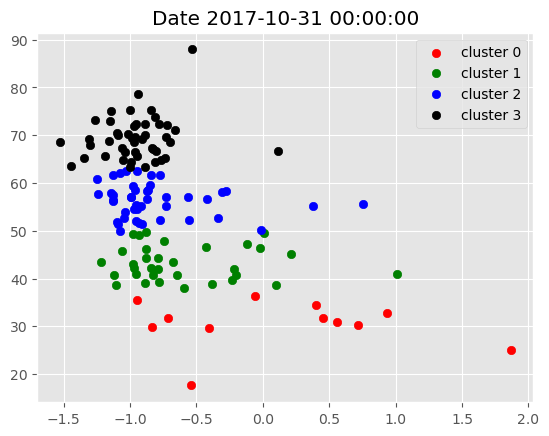

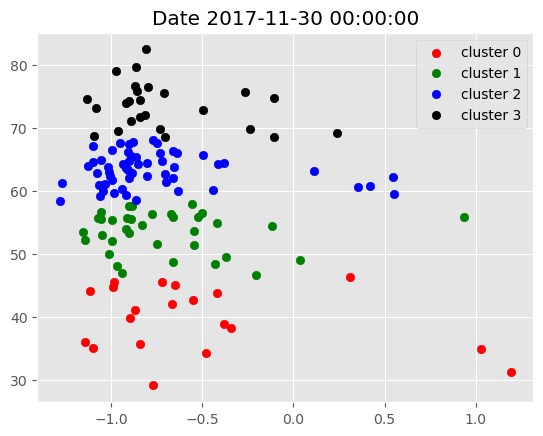

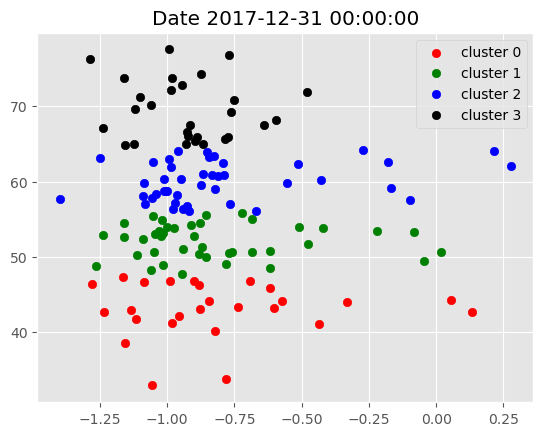

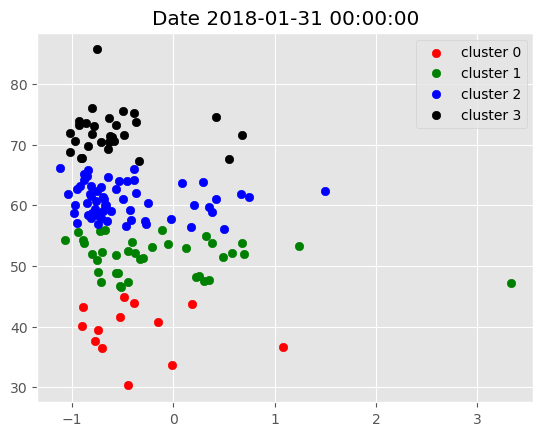

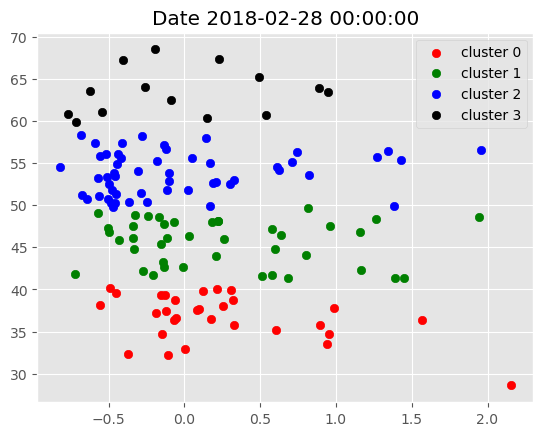

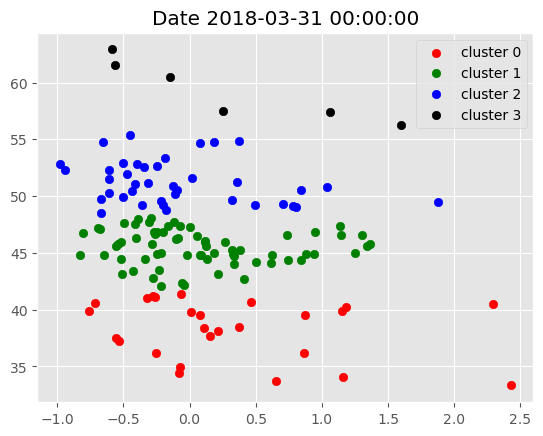

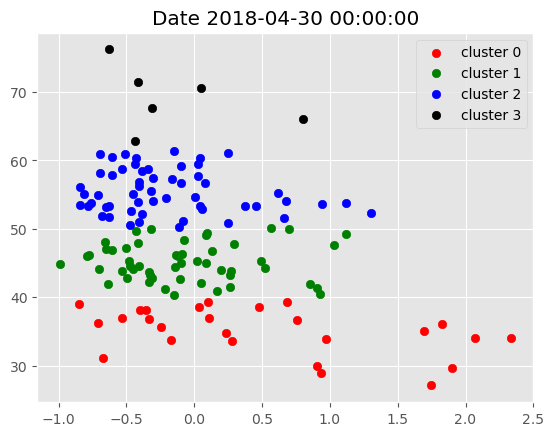

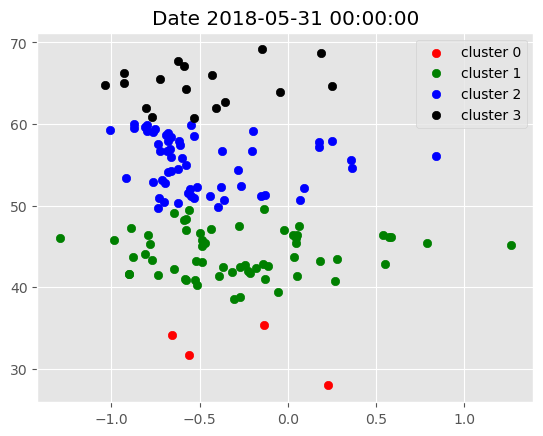

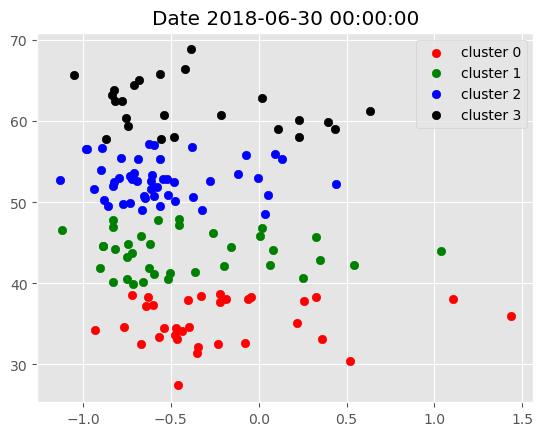

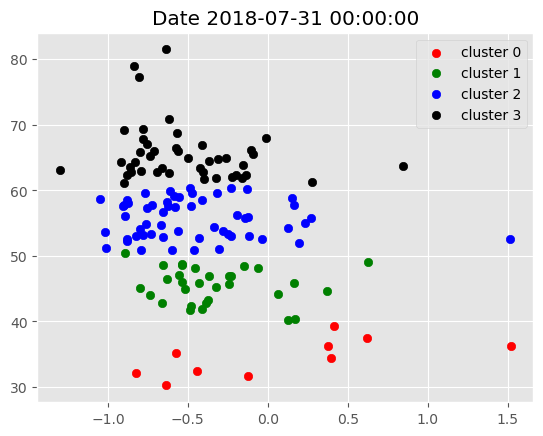

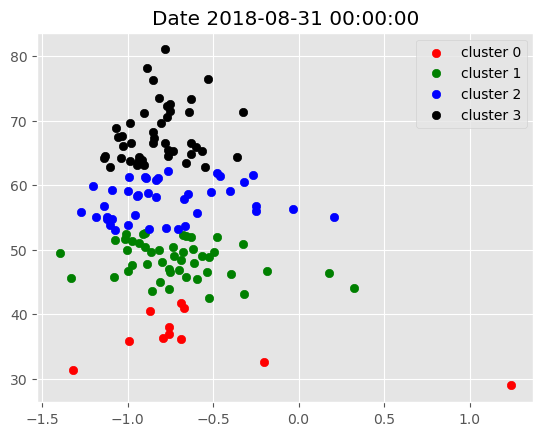

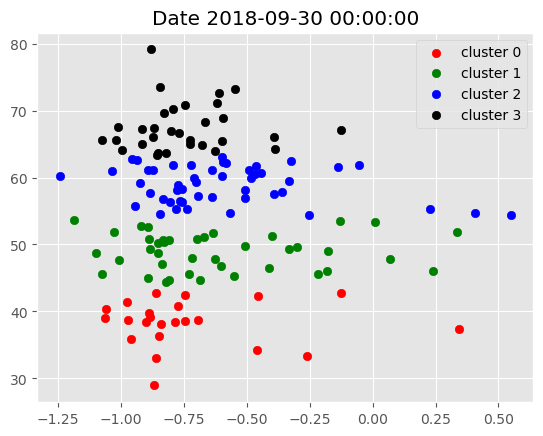

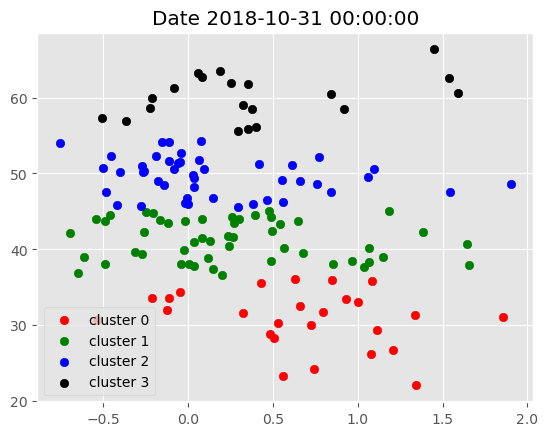

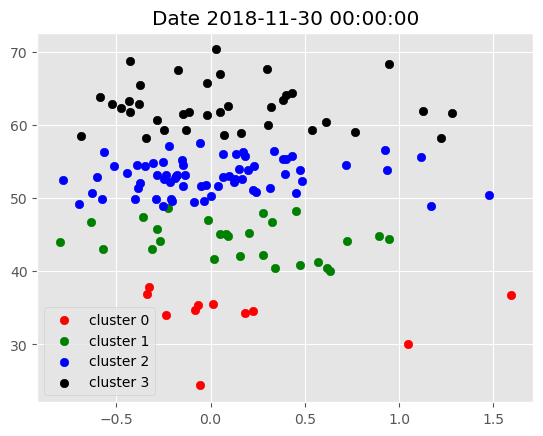

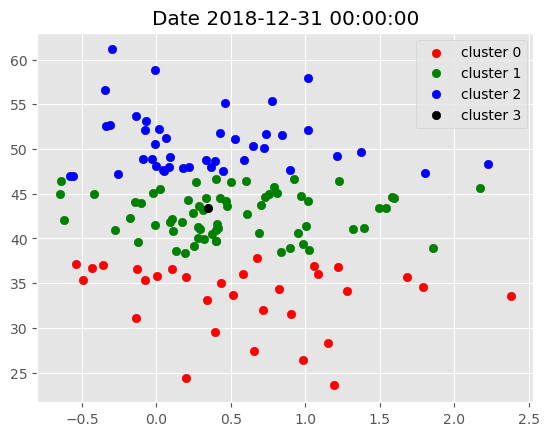

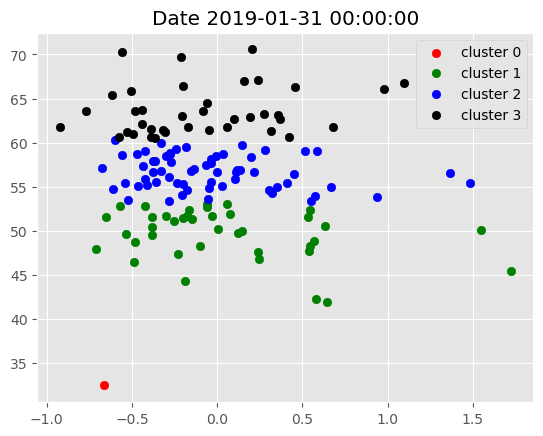

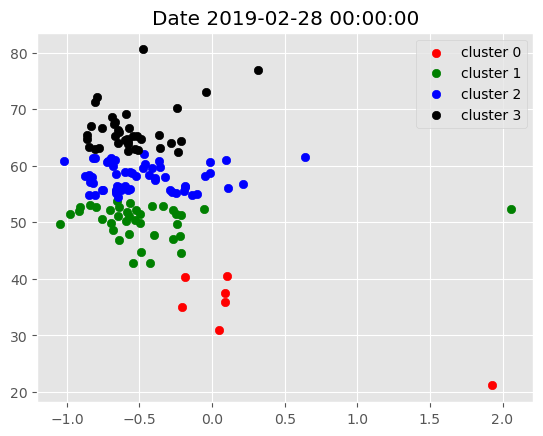

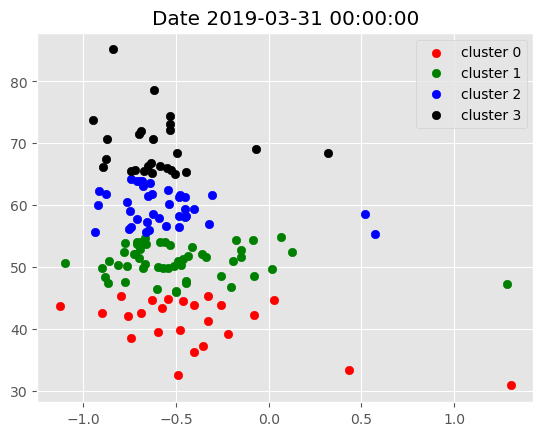

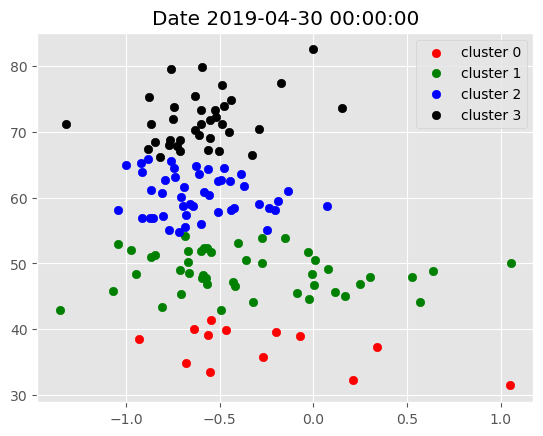

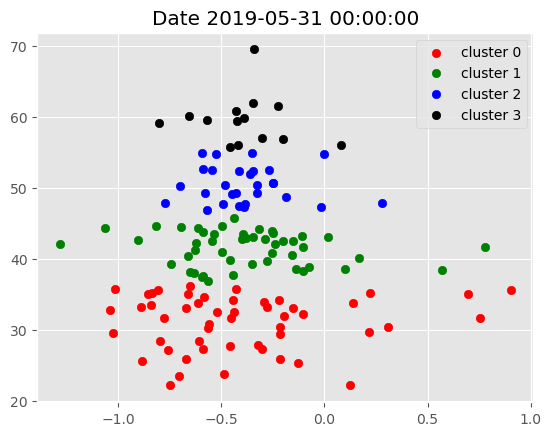

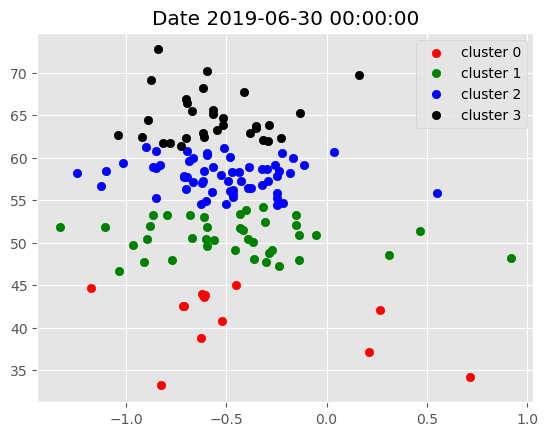

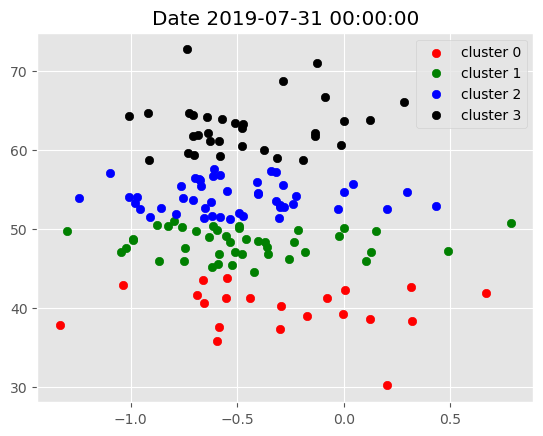

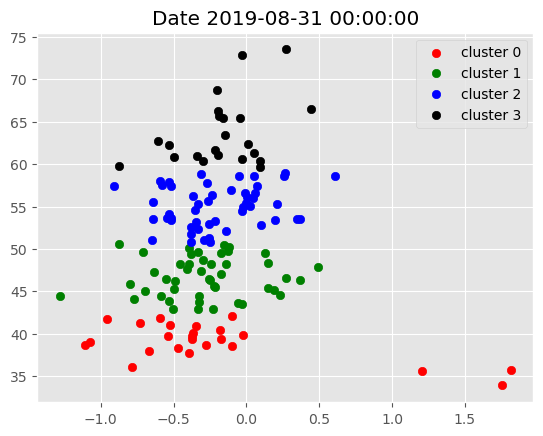

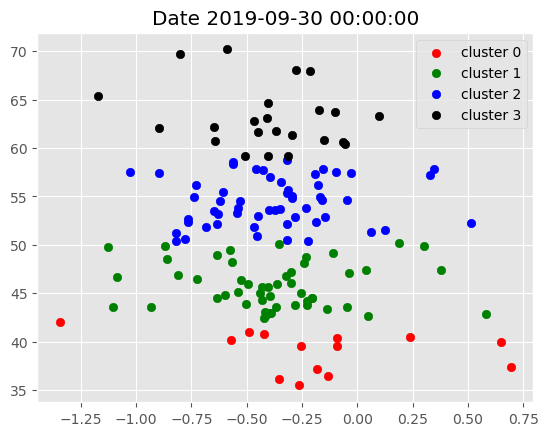

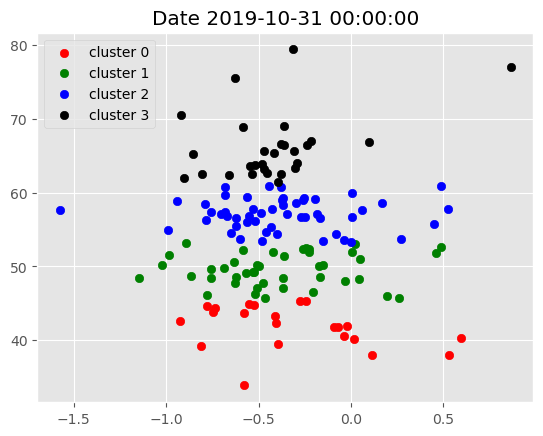

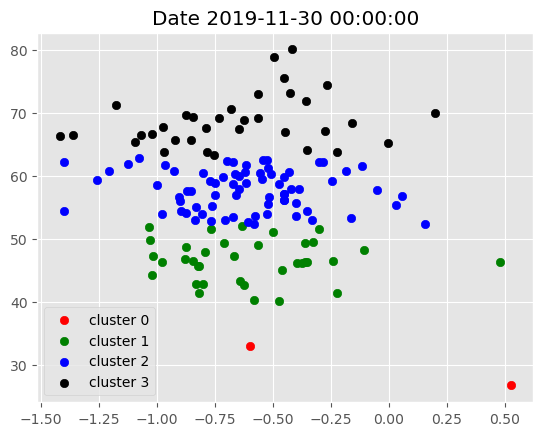

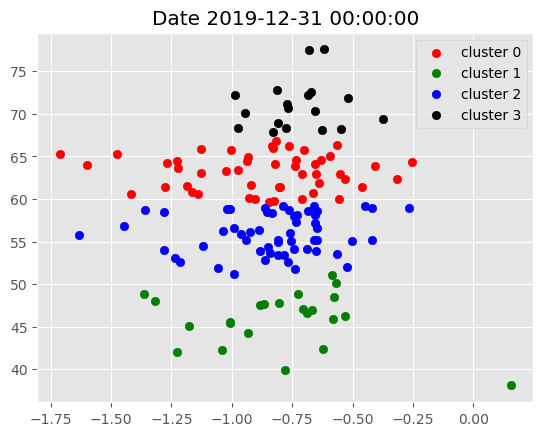

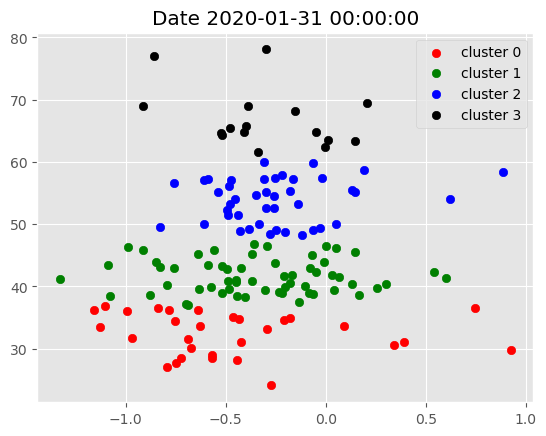

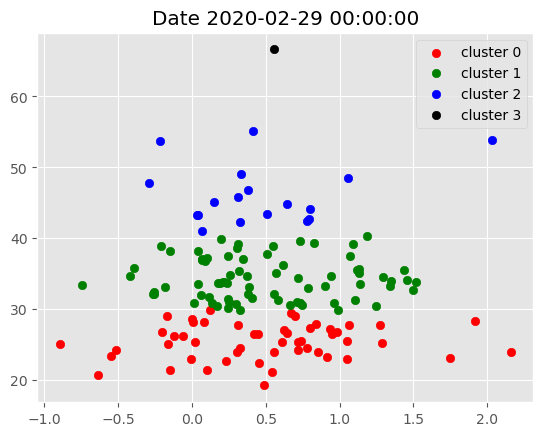

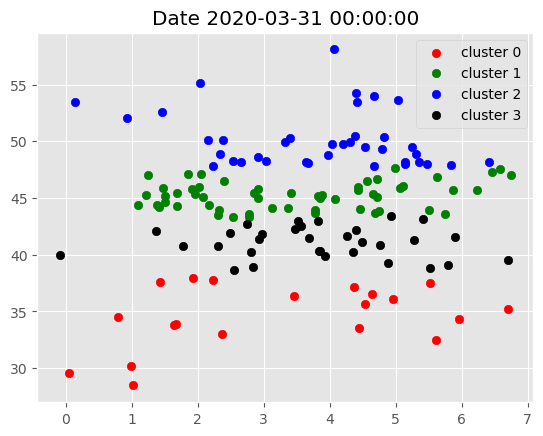

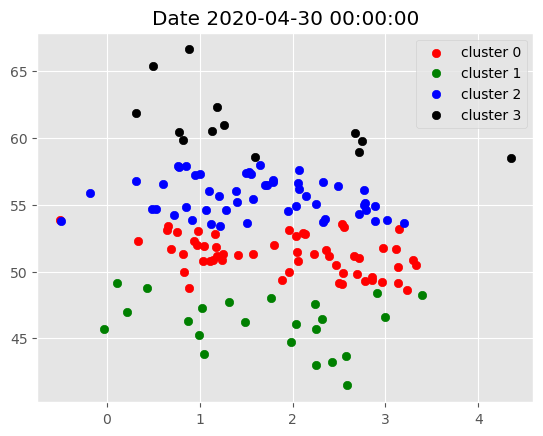

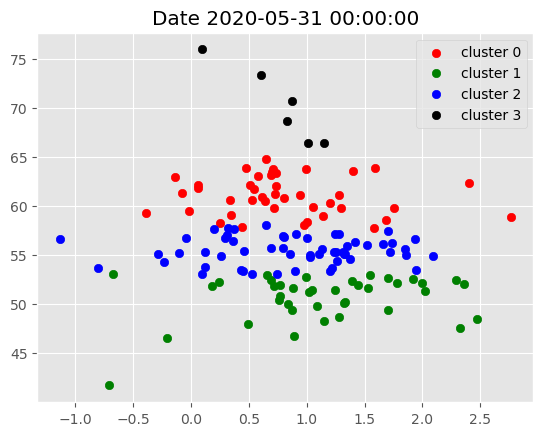

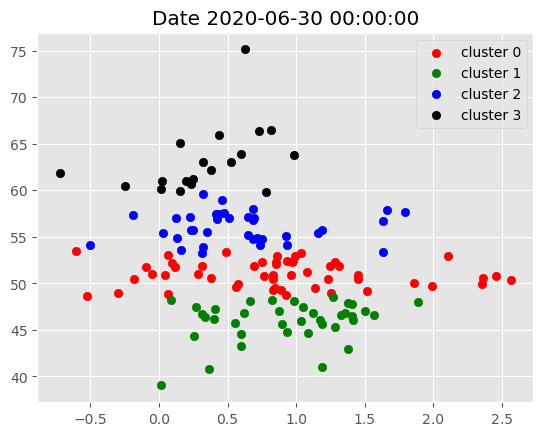

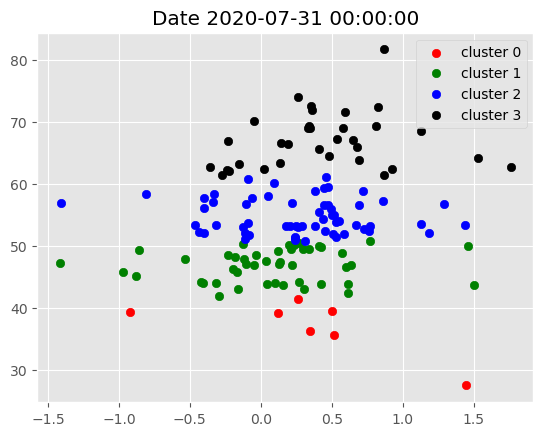

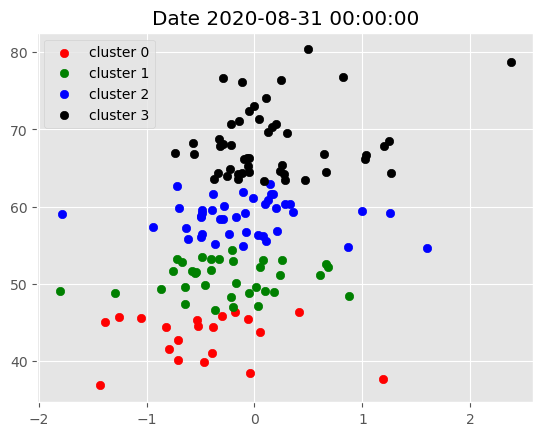

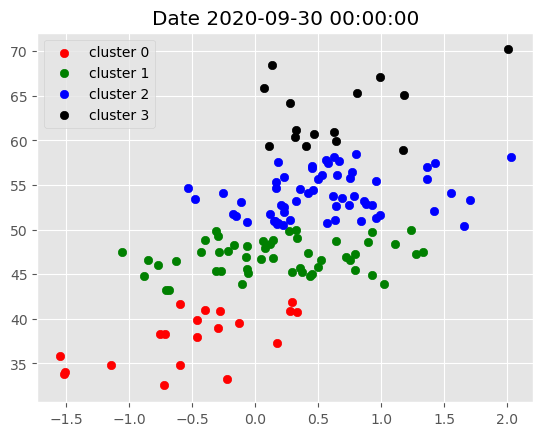

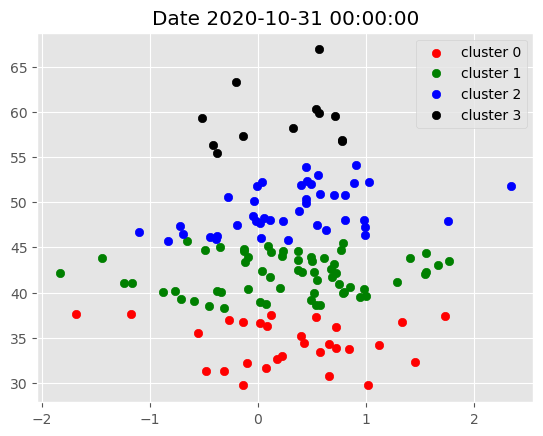

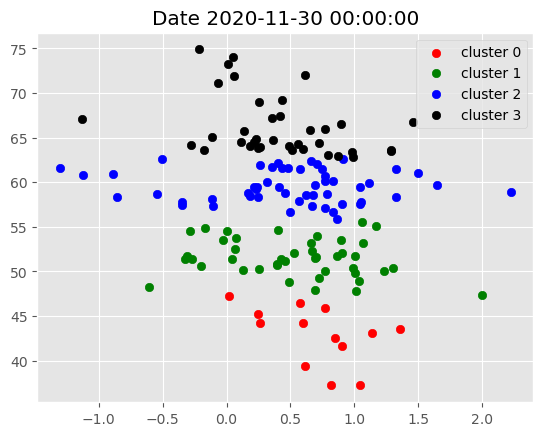

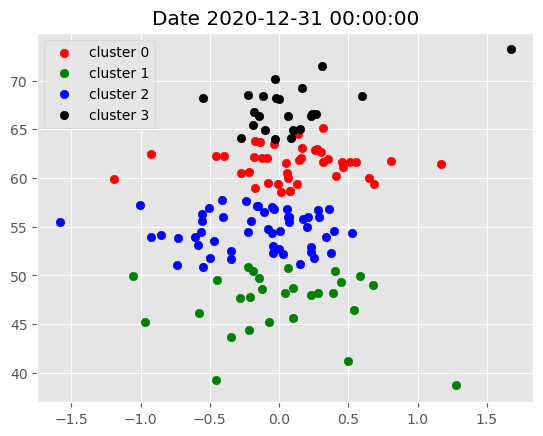

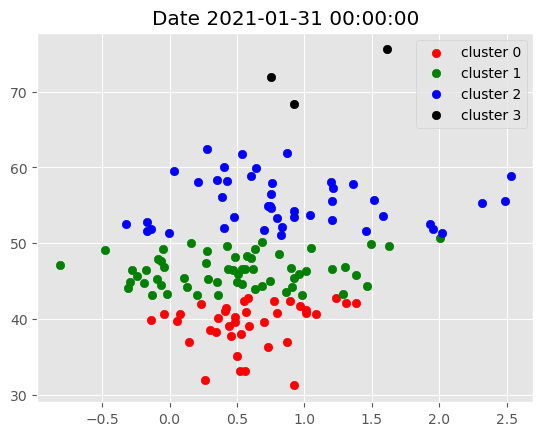

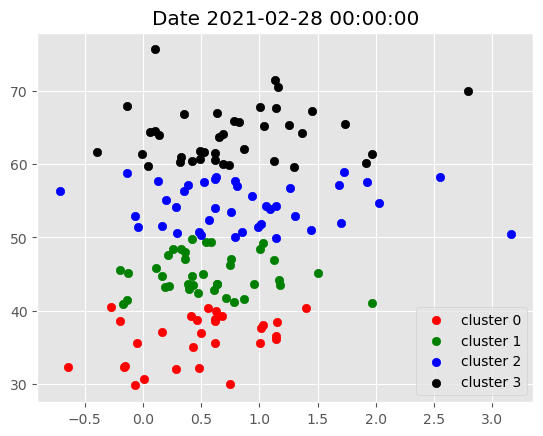

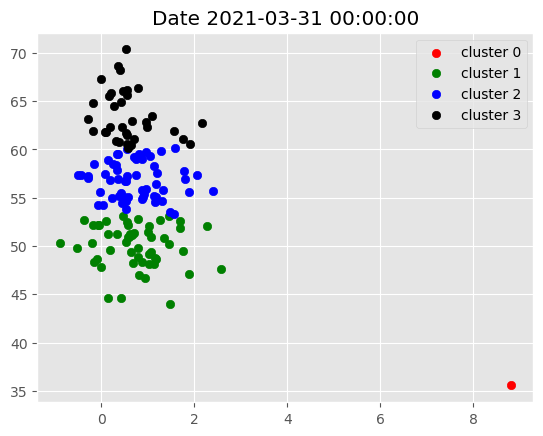

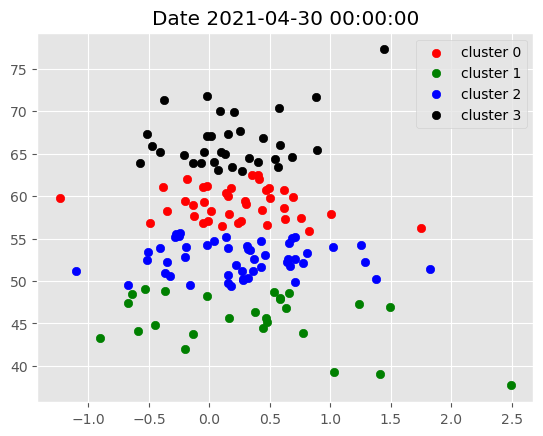

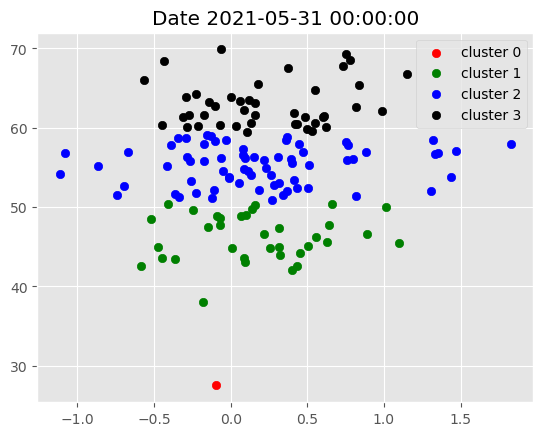

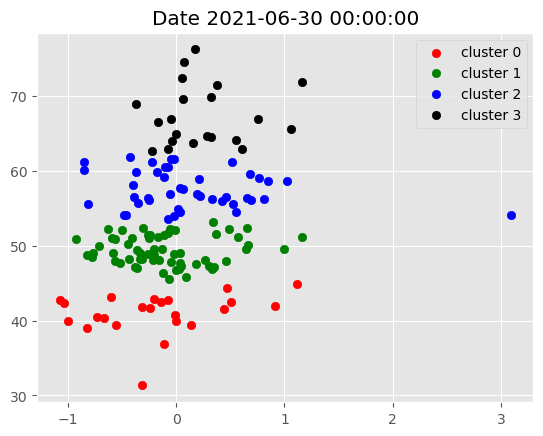

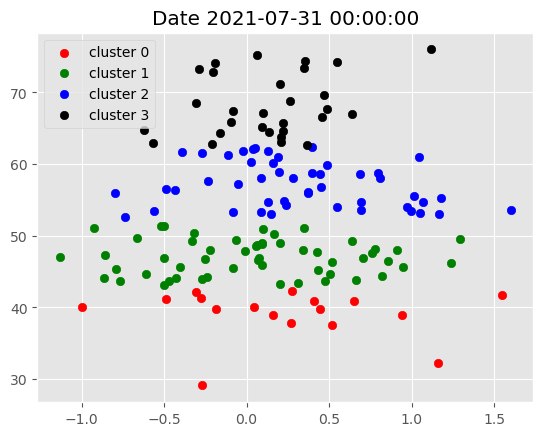

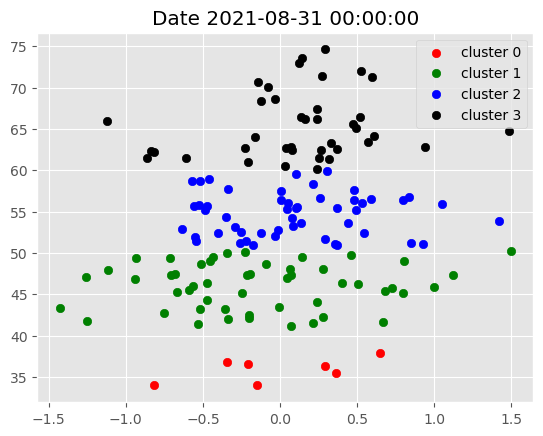

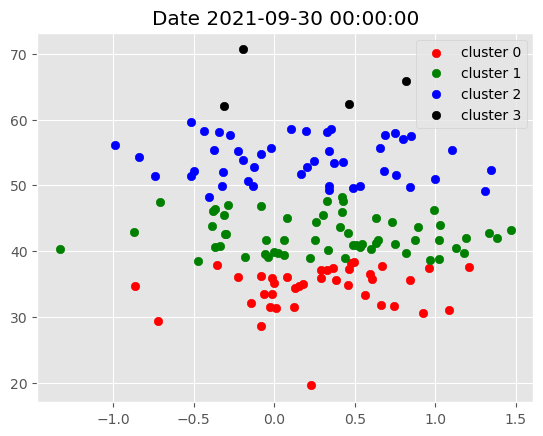

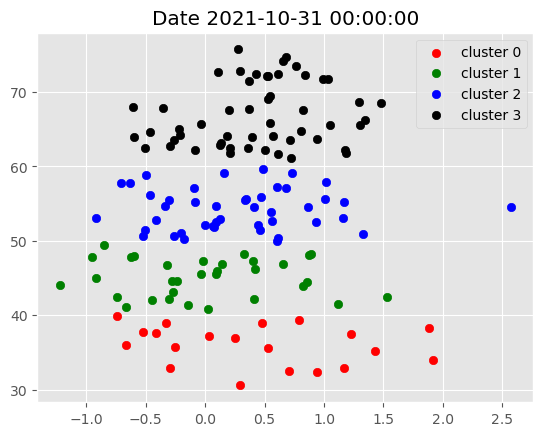

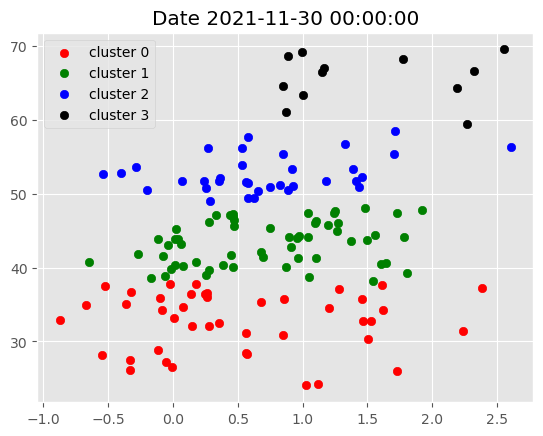

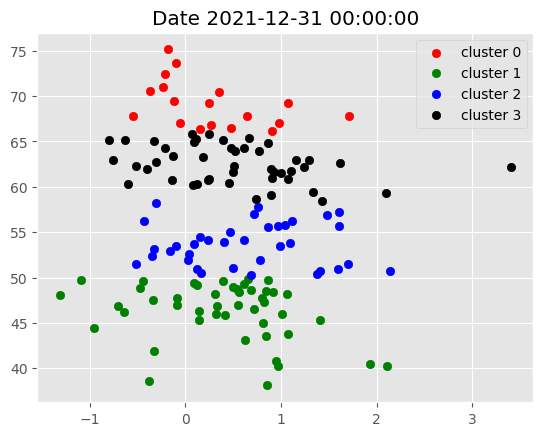

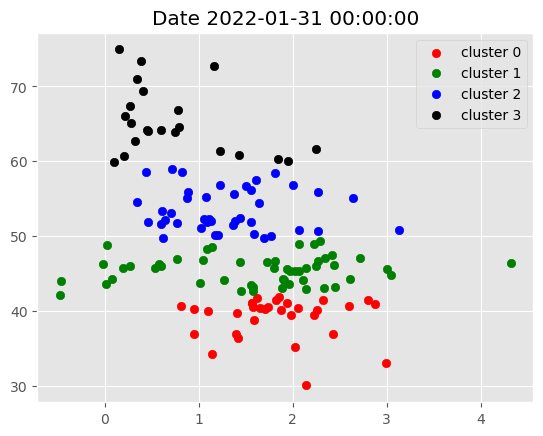

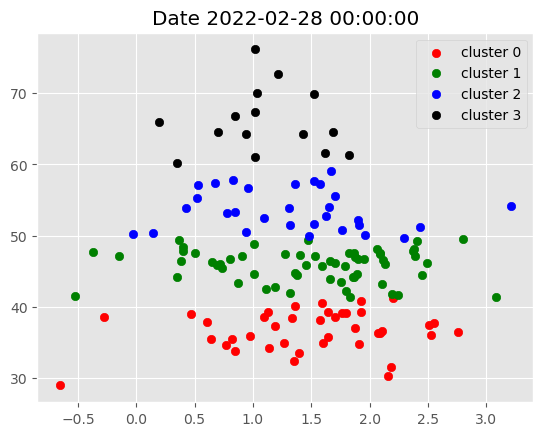

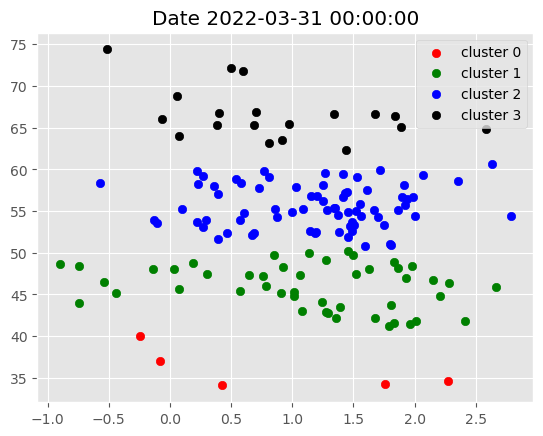

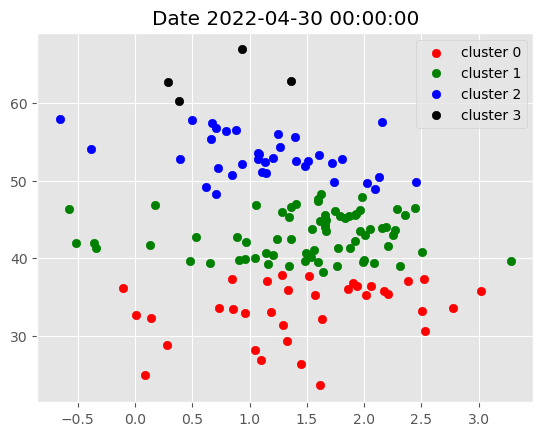

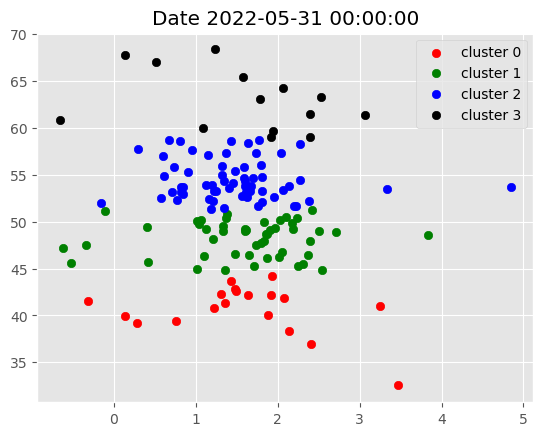

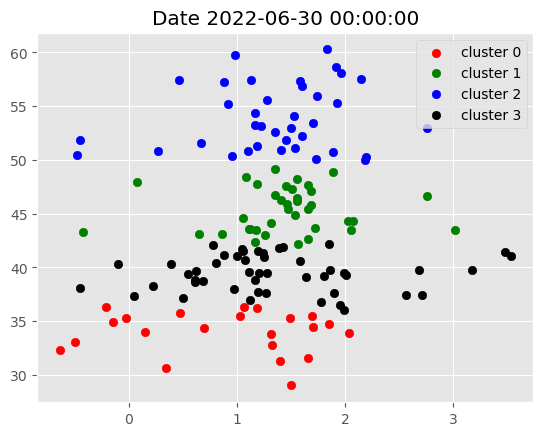

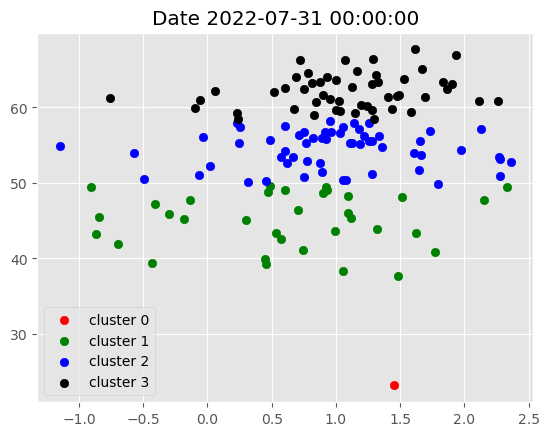

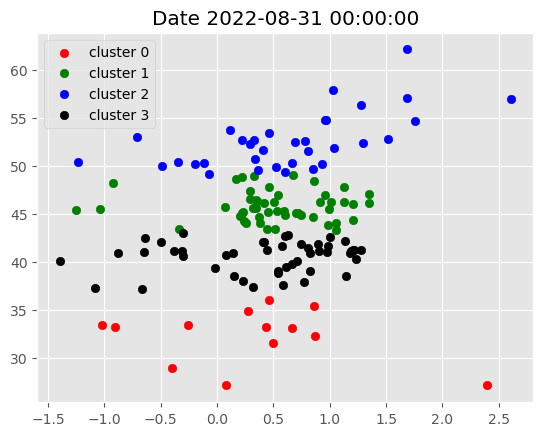

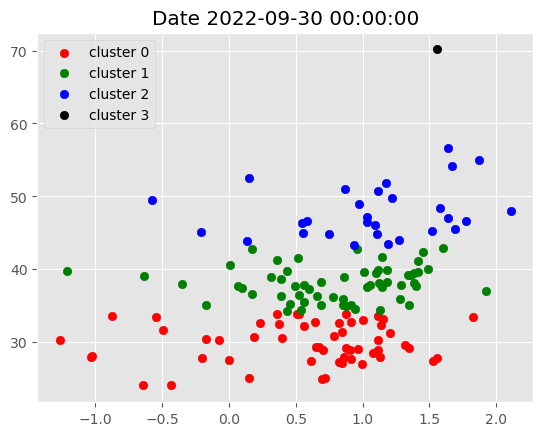

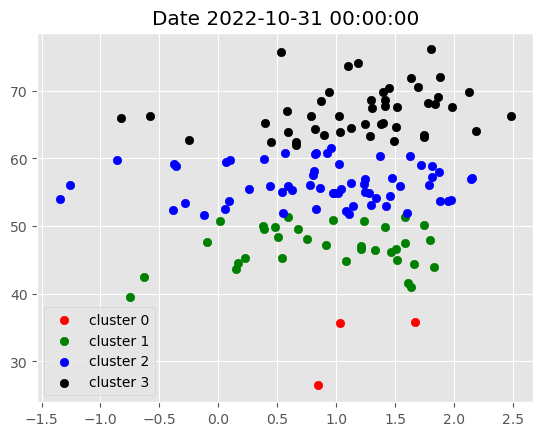

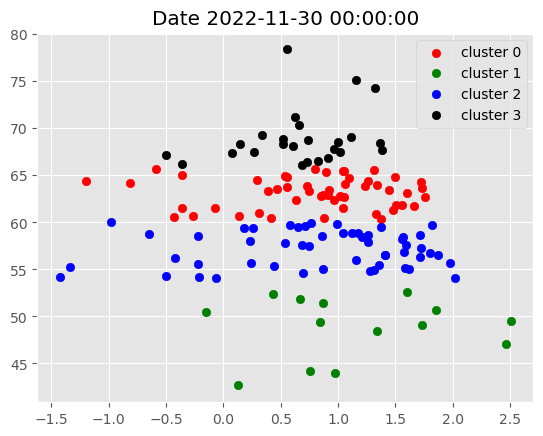

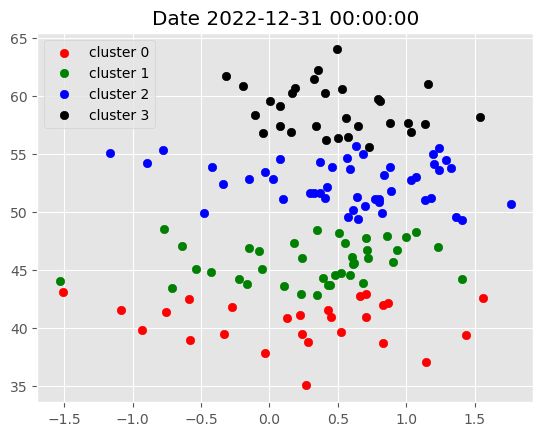

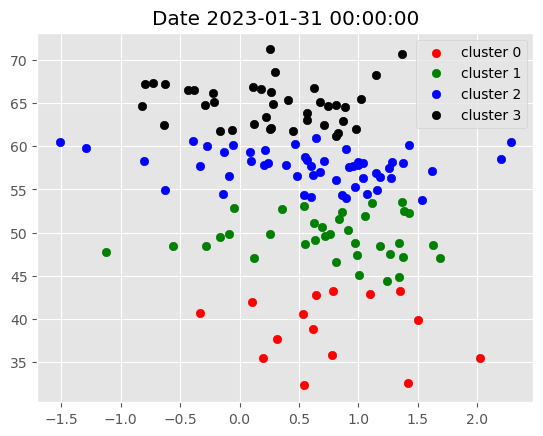

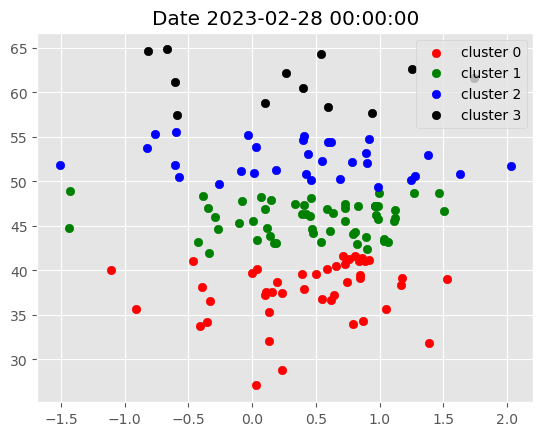

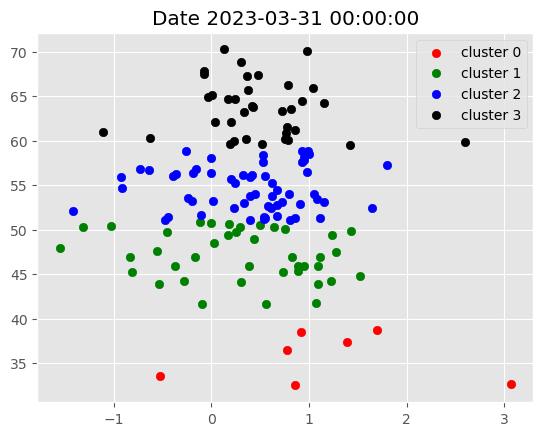

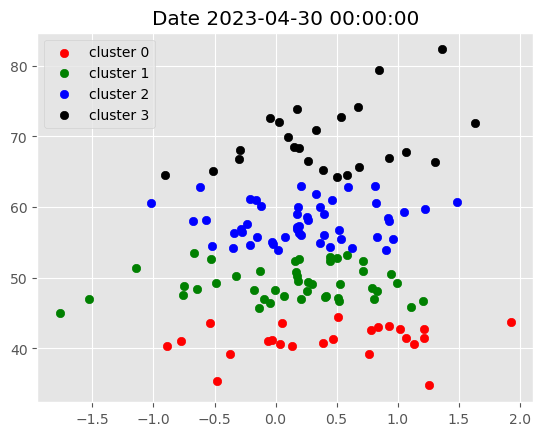

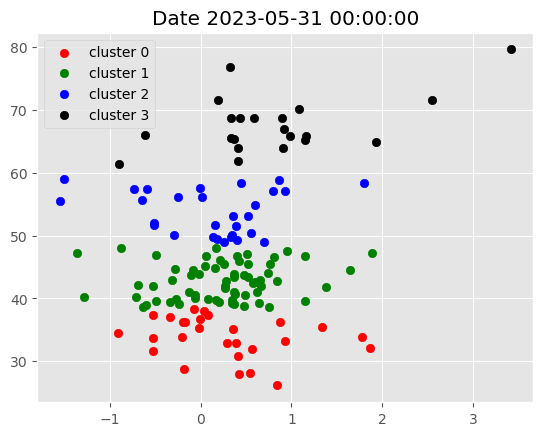

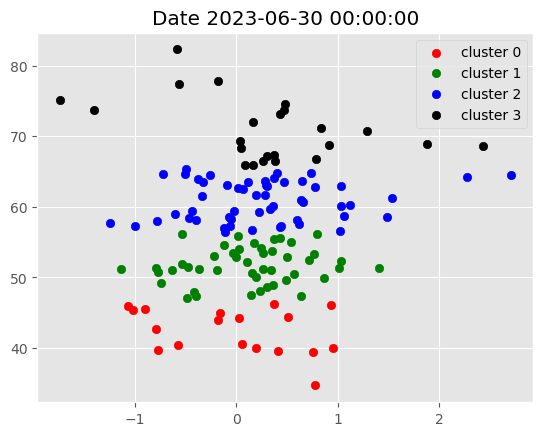

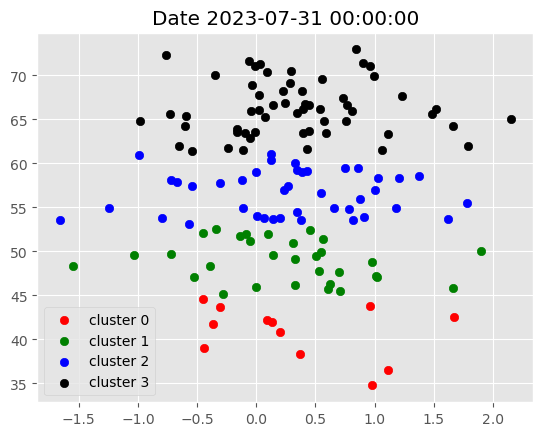

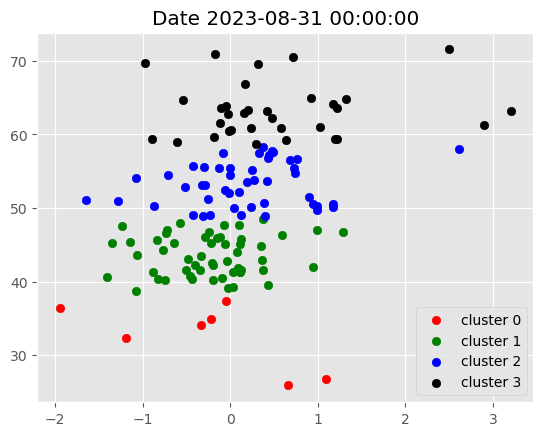

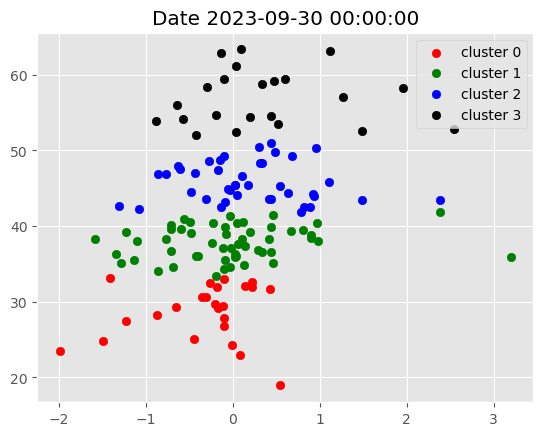

In [15]:
 def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [35]:
#for each onth select asses based on clustering

filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df.set_index(['Ticker'], append=True, inplace=True)
dates = filtered_df.index.get_level_values('Date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COF',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MRO',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'BLK',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'COF',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'MRO',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'AMZN',
  'BA',
  'BAC',
  'B

In [57]:
#portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_return.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound,.1), solvers='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()


In [52]:
stocks = data.index.get_level_values('Ticker').unique().tolist()
new_df = yf.download(tickers=stocks, start=data.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=12), end=data.index.get_level_values('Date').unique()[-1])

[*********************100%%**********************]  155 of 155 completed


In [58]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

weights = optimize_weights(prices=optimization_df, lower_bound=)
optimization_df = new_df['2016-11-01':'2017-10-30']['Adj Close'][cols]
optimization_df


NameError: name 'prices' is not defined